# Задание №1

In [124]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from matplotlib import pyplot as plt

from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LinearRegression

In [73]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
df = pd.read_csv('Статистика за 2016 год.csv', encoding='Windows-1251')

In [33]:
df.columns = ['illdays', 'age', 'gender']

In [39]:
df['age_35'] = df.age > 35
df['ill_target'] = df.illdays > 2
df['is_man'] = df.gender.map({'М': 1, 'Ж': 0})

In [108]:
df.head()

,illdays,age,gender,age_35,ill_target,is_man
0,5,39,Ж,True,True,0
1,4,54,М,True,True,1
2,4,26,М,False,True,1
3,5,42,М,True,True,1
4,4,29,М,False,True,1


In [122]:
print('корелляция мэтьюса возраст/пропуски: ', matthews_corrcoef(df.age_35, df.ill_target))
print('корелляция мэтьюса пол/пропуски: ', matthews_corrcoef(df.is_man, df.ill_target))

корелляция мэтьюса возраст/пропуски:  0.0064975537935991895
корелляция мэтьюса пол/пропуски:  -0.08127697972027877


Корелляция мэтьюса близка к нулю, что означает отсутствие зависимости между целевыми переменными

количество больничных, может зависеть не только от пола, посмотрим, есть ли корреляция с возрастом

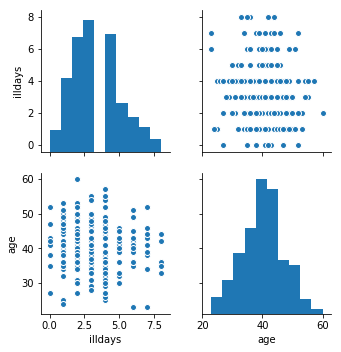

In [81]:
sns.pairplot(df[['illdays', 'age']]);

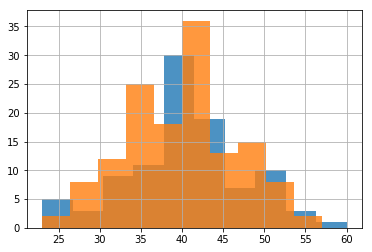

In [82]:
df.groupby('gender').age.hist(alpha=0.8);

Можно сказать, что возраст распределен равномерно для каждого пола, поэтому посмотрим на интервальные оценки для каждого признака:

**Определим интервалы для доли**

In [58]:
conf_interval_man = proportion_confint(sum(df[df.is_man==1]['ill_target']), 
                                            len(df[df.is_man==1]),
                                            method = 'wilson')
conf_interval_woman = proportion_confint(sum(df[df.is_man==0]['ill_target']), 
                                            len(df[df.is_man==0]),
                                            method = 'wilson')

In [60]:
print('interval illness man [%f, %f]' % conf_interval_man)
print('interval illness woman [%f, %f]' % conf_interval_woman)

interval illness man [0.521271, 0.681751]
interval illness woman [0.586161, 0.767329]


Интервалы получились достаточно широкими и пересекаются

In [109]:
conf_interval_man = proportion_confint(sum(df[df.age_35==1]['ill_target']), 
                                            len(df[df.age_35==1]),
                                            method = 'wilson')
conf_interval_woman = proportion_confint(sum(df[df.age_35==0]['ill_target']), 
                                            len(df[df.age_35==0]),
                                            method = 'wilson')

In [110]:
print('interval illness age > 35 [%f, %f]' % conf_interval_man)
print('interval illness age <= 35 [%f, %f]' % conf_interval_woman)

interval illness age > 35 [0.566494, 0.705479]
interval illness age <= 35 [0.501778, 0.744764]


Данных явно недостаточно, чтобы подтвердить гипотезу.

Чтобы уточнить прогнозы, построим интервалы для разности долей:

In [112]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [113]:
proportions_confint_diff_ind(df[df.is_man==1]['ill_target'], df[df.is_man==0]['ill_target'])

(-0.2021803749002104, 0.043466529649880126)

Интервал смещен влево, это может означать, что мужчины пропускают более 2 дней **реже**, чем женщины, но все же данных не достаточно, т.к. интервал содержит 0.

In [114]:
proportions_confint_diff_ind(df[df.age_35==1]['ill_target'], df[df.age_35==0]['ill_target'])

(-0.13623583592680252, 0.15085571896773817)

Гипотезу отвергаем

**проверим совместное влияние признаков с помощью линейной регрессии**

In [90]:
m = LinearRegression()

In [104]:
m.fit(df[['age', 'is_man']], df['ill_target']); m.coef_

array([-0.00355027, -0.08177946])

коэффициенты говорят, что возраст практически не влияет на целевую переменную, а отрицательный коеффициент для мужчин, опять же, говорит, что по имеющимся данным мужчины пропускают реже

** Ответ 1: гипотезу подтвердить нельзя**

** Ответ 2: гипотезу подтвердить нельзя**